In [1]:
initial_path = 'peptide-QML'
# initial_path = '..'

In [2]:
import sys
sys.path.append(initial_path)

%load_ext autoreload
%autoreload 2
from my_code import helper_classes as c
from my_code import pytorch_model as m
from my_code import quantum_nodes as q

In [3]:
# name of the notebook
name_notebook = "sweep_12h_er_Xqm_v3"

In [4]:
# sweep = c.Sweep(
#     name_notebook, 
#     initial_path=initial_path,
#     description="Try to find the best measurement and number of layers for the quantum block using Angle Encoding (repeating embedding with different inputs) and embedding.",
#     repetitions=list(range(1, 3)),
#     embedding_dim=[1,2,4,6],
# )

In [5]:
# sweep.save()

In [6]:
sweep = c.Sweep.load(file_name=name_notebook+"-1", day='0918', initial_path=initial_path)



 --- SWEEP POINT 5/8: (2, 1) ---
 --- time reamining: 65:13:39.60 

Epoch [0/2], Loss epoch: 0.0209, Loss validation: 0.0209
	 Validation string, 	 i: 265; 	 prediction: -0.4646, 	 target: -0.3395, 	 loss: 0.0156
	 Validation string, 	 i: 1825; 	 prediction: -0.2824, 	 target: -0.1932, 	 loss: 0.0080
	 Validation string, 	 i: 3572; 	 prediction: -0.1564, 	 target: -0.1530, 	 loss: 0.0000
Epoch [1/2], Loss epoch: 0.0083, Loss validation: 0.0083, Time remaining: ~0.0h 33.0m 4s
	 Validation string, 	 i: 1559; 	 prediction: -0.1558, 	 target: -0.1380, 	 loss: 0.0003
	 Validation string, 	 i: 528; 	 prediction: -0.2365, 	 target: -0.1202, 	 loss: 0.0135
	 Validation string, 	 i: 1865; 	 prediction: -0.2791, 	 target: -0.3791, 	 loss: 0.0100
Epoch [2/2], Loss epoch: 0.0078, Loss validation: 0.0080, Time remaining: ~0.0h 0.0m 0s


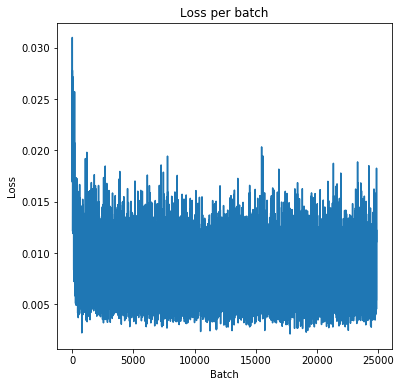

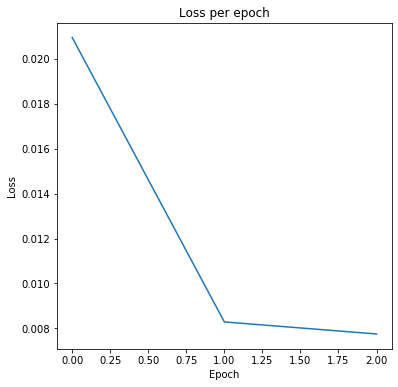

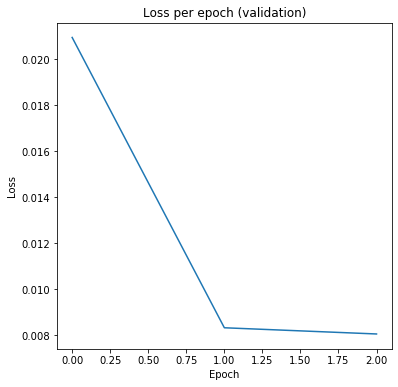

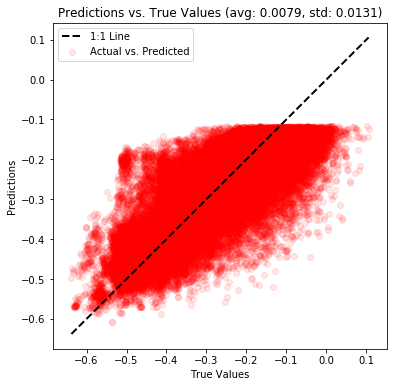

Mean loss: 0.007881338109390778, std loss: 0.013089436795981109


 --- SWEEP POINT 6/8: (2, 2) ---
 --- time reamining: 40:25:02.68 

Epoch [0/2], Loss epoch: 0.0713, Loss validation: 0.0711
	 Validation string, 	 i: 414; 	 prediction: -0.3144, 	 target: -0.1139, 	 loss: 0.0402
	 Validation string, 	 i: 3190; 	 prediction: -0.3889, 	 target: -0.3795, 	 loss: 0.0001
	 Validation string, 	 i: 1171; 	 prediction: -0.4820, 	 target: -0.5278, 	 loss: 0.0021
Epoch [1/2], Loss epoch: 0.0073, Loss validation: 0.0066, Time remaining: ~0.0h 47.0m 54s
	 Validation string, 	 i: 2652; 	 prediction: -0.3550, 	 target: -0.5016, 	 loss: 0.0215
	 Validation string, 	 i: 2816; 	 prediction: -0.1951, 	 target: -0.2368, 	 loss: 0.0017
	 Validation string, 	 i: 4109; 	 prediction: -0.1529, 	 target: -0.2363, 	 loss: 0.0070
Epoch [2/2], Loss epoch: 0.0066, Loss validation: 0.0064, Time remaining: ~0.0h 0.0m 0s


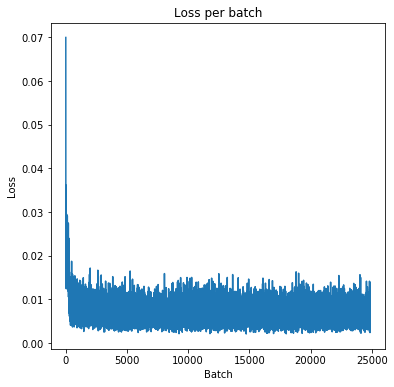

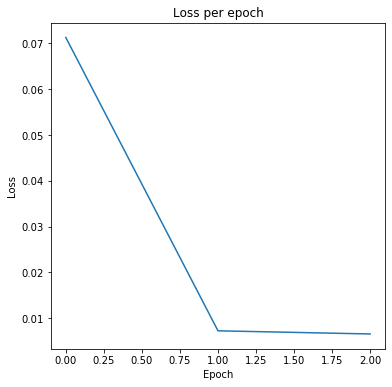

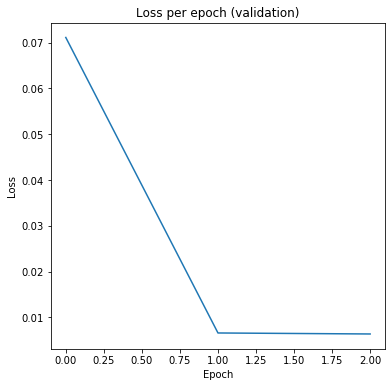

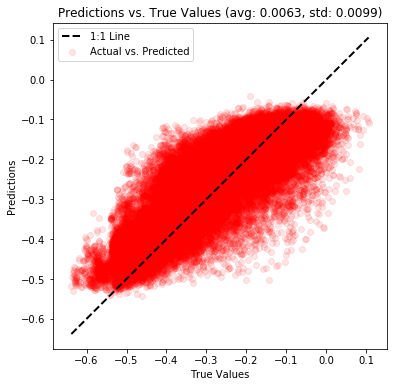

Mean loss: 0.0063458719157105355, std loss: 0.009949701644155503


 --- SWEEP POINT 7/8: (2, 4) ---
 --- time reamining: 23:22:14.54 

Epoch [0/2], Loss epoch: 0.4816, Loss validation: 0.4824


In [7]:
for sweep_point in sweep.points_left:

    if sweep_point['embedding_dim'] == 6:
        continue

    # print the point of the sweep
    sweep.print_sweep_status(sweep_point['idx'])

    # -- QUANTUM BLOCK -- #
    n_qubits = 6
    quantum_layer = q.circuit(
        n_qubits = n_qubits, 
        device = "default.qubit.torch",
        device_options = {'shots': None},
        embedding = q.parts.AngleEmbedding, 
        embedding_ansatz = q.parts.Ansatz_11,
        block_ansatz = q.parts.Ansatz_11,
        final_ansatz = q.parts.Ansatz_11, # TODO CHECK IF THIS IS THE BEST OPTION
        measurement = q.parts.Measurement('Z', 'all'),
        embedding_n_layers = sweep_point['embedding_dim']*2-1,
        different_inputs_per_layer = True,
        block_n_layers = 10,
        # wrapper_qlayer = pw.QLayerEmpty,
    )

    # -- MODEL -- #                    
    class Model(m.Model):
        def __init__(self):
            super(Model, self).__init__()
            self.fc1 = m.nn.Embedding(num_embeddings=19, embedding_dim=sweep_point['embedding_dim'])
            self.fc2 = m.Reshape()
            self.fc3 = quantum_layer()            
            self.fc4 = m.nn.Sequential(*[m.nn.Linear(6, 6), m.nn.Sigmoid(), m.nn.Linear(6, 1)])

        def forward(self, x):
            for i in range(1,5):
                x = getattr(self, 'fc{}'.format(i))(x)
            return x

    model = Model()

    # set quantum layer
    model.set_quantum_layer(quantum_layer)

    # set the name and path of the model
    model.set_name_and_path(name_notebook, initial_path)

    #set sweep point
    model.set_sweep_point(
        sweep_uuid = sweep.uuid,
        sweep_point = sweep_point,
        day=sweep.day
    )

    # -- TRAIN -- #
    model.optimize_params(
        #save info
        save_model_info = True,
        description = 'sweep with 12 amino acids and {} qubits using Angle Encoding (repeating embedding) and classical Embedding'.format(n_qubits),    
        #data
        data=c.Data.load(initial_path=initial_path, file_name='PET_SCORES_12_Numbers_int'),
        # train options
        optimizer = m.optim.Adam,
        optimizer_options = {'lr': 0.01},
        num_epochs = 2,                
        batch_size = 32,
        # early stopping options
        stop_training_options = {
            'lookback_epochs': 5, 
            'threshold_slope': 0.001,
            'threshold_std_dev': 0.2
        },
        # metadata
        metadata = {}
    )

    # -- VALIDATION and PLOTS -- #
    model.plot_losses(fig_size=(6,6))
    model.validate(
        pct=1,
        add_to_results=True,
        plot=True,
        print_items=False
    )

    # -- SAVE RESULTS -- #
    model.save_results()

    # -- ADD DATA GENERATED TO SWEEP -- #
    sweep.add_data(
        idx=sweep_point['idx'],
        model_uuid=model.uuid,
        best_loss_train=model.results.loss_epoch.best,
        best_loss_test=model.results.loss_validation_epoch.best,
        loss_validation=model.mean_loss_validation,
        n_parameters=model.n_parameters,
        time_train=model.results.time_epoch.last,
    )
    sweep.save(csv=False) #TODO: save csv=False automatically when sweep is already saved ion csv

    